In [61]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.max_columns', None)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold


In [62]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

In [63]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [64]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [65]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [66]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [67]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [68]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [69]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

### MODELING 

In [70]:
# dropping meta data columns
play2024_df = play2024_df.drop(columns=["play_id","game_id","old_game_id"])

In [71]:
#number of columns that have numerical values
num_cols = play2024_df.select_dtypes(include=[np.number]).columns
#keep only numerical columns
play2024_df = play2024_df[num_cols]
#fill NaN values with 0

In [72]:
play2024_df = play2024_df.fillna(0)

In [73]:
play2024_df.head()

,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passing_yards,receiving_yards,rushing_yards,lateral_receiving_yards,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,tackle_with_assist,tackle_with_assist_2_player_id,tackle_with_assist_2_player_name,tackle_with_assist_2_team,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,season,cp,cpoe,series,series_success,order_sequence,play_clock,play_deleted,special_teams_play,st_play_type,end_yard_line,fixed_drive,drive_play_count,drive_first_downs,drive_inside20,drive_ended_with_score,drive_quarter_start,drive_quarter_end,drive_yards_penalized,drive_play_id_started,drive_play_id_ended,away_score,home_score,result,total,spread_line,total_line,div_game,temp,wind,aborted_play,success,passer_jersey_number,rusher_jersey_number,receiver_jersey_number,pass,rush,first_down,special,play,jersey_number,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,was_injured,missed_time
0,1,0.0,900.0,1800.0,3600.0,0,0.0,0,1,0.0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0.0,3,3,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.770222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.433208,0.566792,0.566792,0.433208,0.000000,0.000000,0.000000,0.000000,0.000000,0.250386

In [74]:
#splitting data into training and testing
X = play2024_df.drop(columns=["was_injured", "missed_time"])
y = play2024_df["was_injured"]

In [75]:
print("X shape:", X.shape)

X shape: (26345, 221)


In [76]:
def remove_low_variance_features(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    return X.columns[selector.get_support()]

In [77]:
low_variance_features = remove_low_variance_features(X)
# remove low variance features
X = X[low_variance_features]

print("Number of features after removing low variance features:", len(X.columns))

Number of features after removing low variance features: 158


In [78]:
print("Number of low variance features:", len(low_variance_features))

Number of low variance features: 158


In [79]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [80]:
fvalue_selector = SelectKBest(f_classif, k=128)
X_kbest = fvalue_selector.fit_transform(X, y)

In [81]:
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 158
Reduced number of features: 128


In [82]:
X = pd.DataFrame(X_kbest)

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [85]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Distribution of classes in y_train:", y_train.value_counts())
print("---------------------")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Distribution of classes in y_test:", y_test.value_counts())

X_train shape: (23710, 128)
y_train shape: (23710,)
Distribution of classes in y_train: was_injured
0    23301
1      409
Name: count, dtype: int64
---------------------
X_test shape: (2635, 128)
y_test shape: (2635,)
Distribution of classes in y_test: was_injured
0    2587
1      48
Name: count, dtype: int64


In [86]:
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=10)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribution of classes in y_train_resampled:", y_train_resampled.value_counts())

Distribution of classes in y_train_resampled: was_injured
0    23301
1    23301
Name: count, dtype: int64


In [87]:
#normalize all columns in the dataframe
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [88]:
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_train_resampled = pd.DataFrame(X_train_resampled)
X_test = scaler.transform(X_test)

In [89]:
print("Number of injury cases:", len(y_train_resampled[y_train_resampled == 1]))
print("Number of non-injury cases:", len(y_train_resampled[y_train_resampled == 0]))

Number of injury cases: 23301
Number of non-injury cases: 23301


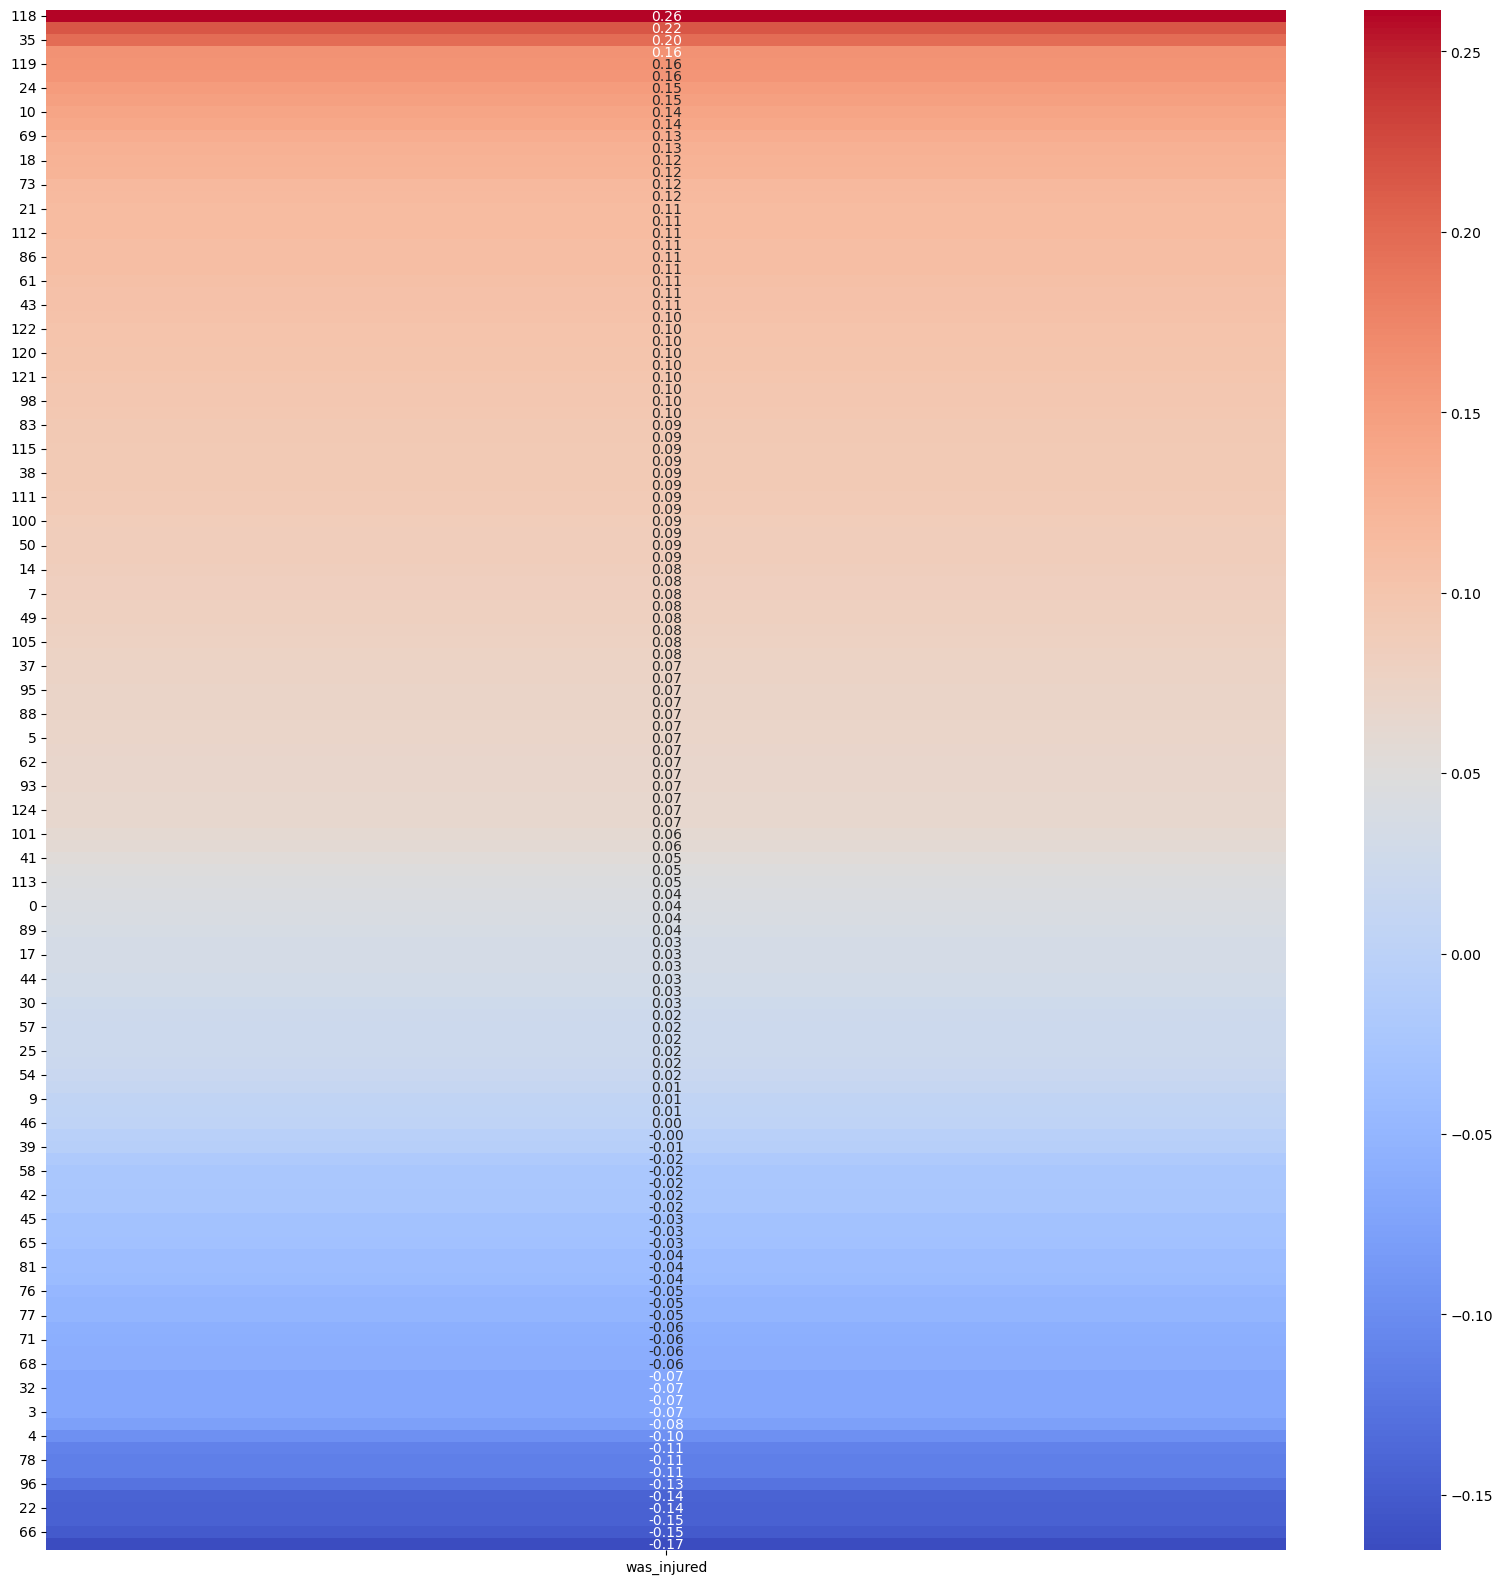

<Figure size 640x480 with 0 Axes>

In [90]:
#dis[lpay correlation matrix
new_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)
corr = new_df.corr()[["was_injured"]].sort_values(by="was_injured", ascending=False)
corr = corr.drop("was_injured")
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
plt.savefig("correlation_matrix.png")

In [91]:
#import shuffler
from sklearn.utils import shuffle

In [92]:
X_train_injury = X_train[y_train == 1]
X_train_no_injury = X_train[y_train == 0]

print("X_train_injury shape:", X_train_injury.shape)
print("X_train_no_injury shape:", X_train_no_injury.shape)

X_train_no_injury_downsampled = resample(X_train_no_injury, replace=False, n_samples=len(X_train_injury), random_state=42)

X_train_downsampled = pd.concat([X_train_no_injury_downsampled, X_train_injury])
y_train_downsampled = pd.Series([0] * len(X_train_no_injury_downsampled) + [1] * len(X_train_injury))

#shuffle the data
X_train_downsampled, y_train_downsampled = shuffle(X_train_downsampled, y_train_downsampled, random_state=42)

print("X_train_downsampled shape:", X_train_downsampled.shape)

X_train_injury shape: (409, 128)
X_train_no_injury shape: (23301, 128)
X_train_downsampled shape: (818, 128)


In [93]:
classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
}

Classifier:  LogisticRegression
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.67      0.80      2587
           1       0.03      0.58      0.06        48

    accuracy                           0.67      2635
   macro avg       0.51      0.63      0.43      2635
weighted avg       0.97      0.67      0.78      2635



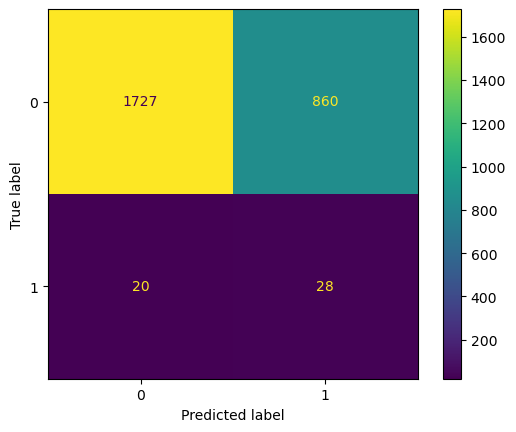

Classifier:  KNeighborsClassifier
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2587
           1       0.02      0.15      0.04        48

    accuracy                           0.85      2635
   macro avg       0.50      0.51      0.48      2635
weighted avg       0.96      0.85      0.91      2635



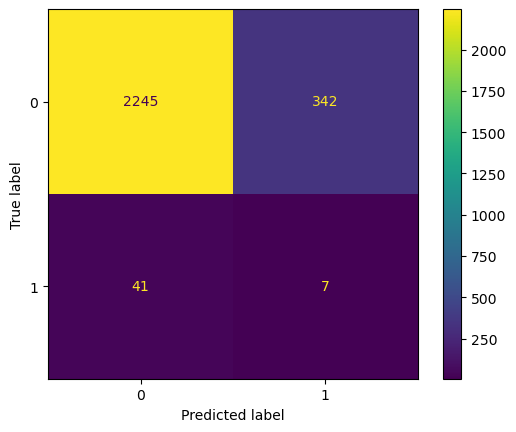

Classifier:  SVC
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2587
           1       0.07      0.06      0.07        48

    accuracy                           0.97      2635
   macro avg       0.53      0.52      0.53      2635
weighted avg       0.97      0.97      0.97      2635



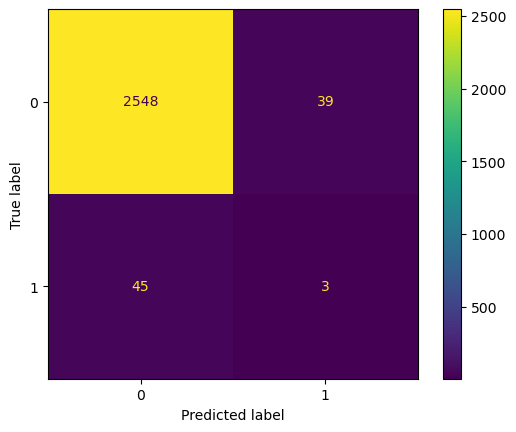

Classifier:  DecisionTreeClassifier
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2587
           1       0.03      0.04      0.03        48

    accuracy                           0.96      2635
   macro avg       0.50      0.51      0.50      2635
weighted avg       0.96      0.96      0.96      2635



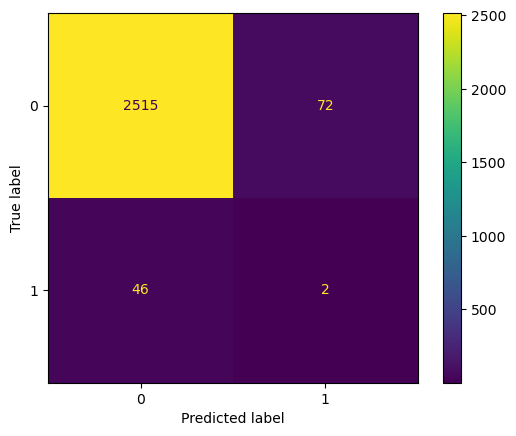

In [94]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_resampled, y_train_resampled)
    print("Classifier: ", classifier.__class__.__name__)
    print("Classification Report: ")
    print(classification_report(y_test, classifier.predict(X_test)))

    cm = confusion_matrix(y_test, classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim

In [96]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

print(X_train_downsampled.shape)
print(y_train_downsampled.shape)

(46602, 128)
(46602,)
(818, 128)
(818,)


In [97]:
X_train_resampled = torch.tensor(X_train_resampled.values).float()
y_train_resampled = torch.tensor(y_train_resampled.values).float()

X_train_downsampled = torch.tensor(X_train_downsampled.values).float()
y_train_downsampled = torch.tensor(y_train_downsampled.values).float()

In [98]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test.values).float()

In [99]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)
        out = self.sigmoid(out)

        return out
    

Epoch 0 Loss: 0.6985727548599243
Epoch 5 Loss: 0.6711592674255371
Epoch 10 Loss: 0.6474472880363464
Epoch 15 Loss: 0.6252333521842957
Epoch 20 Loss: 0.6063446998596191
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81      2587
         1.0       0.03      0.46      0.05        48

    accuracy                           0.69      2635
   macro avg       0.51      0.58      0.43      2635
weighted avg       0.97      0.69      0.80      2635



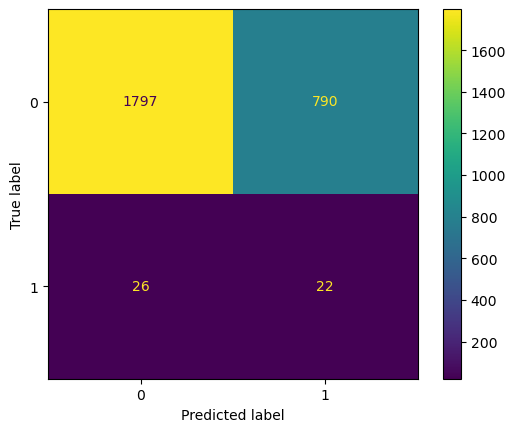

In [100]:
model = NeuralNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(25):
    optimizer.zero_grad()
    outputs = model(X_train_resampled)
    loss = criterion(outputs.squeeze(), y_train_resampled)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")

with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs).squeeze()
    print("Classification Report: ")
    print(classification_report(y_test, predicted.numpy()))
    cm = confusion_matrix(y_test, predicted.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()